<a href="https://colab.research.google.com/github/jaehyun0220/Colab/blob/master/SDS_FeatureEngineering_Sampling_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3조. 건강검진 데이터를 활용한 치석 발생 예측

## - Version 3. 변수 파생 (Next Step. 추가 외부 변수 결합)'

## 1. 작업 환경 세팅

### 1-1. 구글 드라이브 인증

In [4]:
# Auth 인증 및 Google Drive 활용 Data load
# from google.colab import auth
# auth.authenticate_user()
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# 학교 g guite 사용 시: 학교 g suite 구글 드라이브에 연결해 놓았으니, 성대 킹고 로그인해서 구글 드라이브 켜놓고 아래 결과창에 나오는 url 클릭해서 성대 gmail로 로그인하면 됨
# 데이터 경로는 본인 drive 내의 /sds/data 경로로 fix

# Google Drive 내 Custom Class 경로 지정
import sys
sys.path.insert(0, '/gdrive/My Drive/CustomClasses')

Mounted at /gdrive


In [5]:
!ls /gdrive/My\ Drive/sds/data

 NHIS_OPEN_GJ_2012.csv
 NHIS_OPEN_GJ_2013.csv
 NHIS_OPEN_GJ_2014.csv
 NHIS_OPEN_GJ_2015.csv
 NHIS_OPEN_GJ_2016.csv
 NHIS_OPEN_GJ_2017.csv
'NHIS_OPEN_GJ 건강검진 데이터 연도별 데이터 레이아웃.xlsx'
 NHIS_OPEN_T20_2012.csv
 NHIS_OPEN_T20_2013.csv
 NHIS_OPEN_T20_2014.csv
 NHIS_OPEN_T20_2015.csv
 NHIS_OPEN_T20_2016.csv
 NHIS_OPEN_T20_2017.csv
'NHIS_OPEN_T20 진료내역정보_활용방안.txt'


### 1-2. 라이브러리 로딩

In [6]:
# 기본 라이브러리 로드
import pandas as pd

# pd.set_option('display.float_format', '{:.6f}'.format) # 항상 float 형식으로
# pd.set_option('display.float_format', '{:.2e}'.format) # 항상 사이언티픽
# pd.set_option('display.float_format', '{:.2g}'.format)  # 적당히 알아서
# pd.set_option('display.float_format', None) # option 삭제

import numpy as np
import os, sys

from tqdm import tqdm_notebook

import re
import tensorflow as tf

#데이터 전처리 관련 라이브러리 로드
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit

#모델 알고리즘 로드
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier


# Deep Learning Model 로드
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation 
from keras.wrappers.scikit_learn import KerasClassifier

#HyperParameter Tuning을 위한 라이브러리 로드
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#모델 평가를 위한 라이브러리 로드
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn import model_selection

#수학 & 통계 관련 라이브러리 로드
import scipy.stats as st
from collections import Counter

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Visualization
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
import seaborn as sns

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

Using TensorFlow backend.


In [7]:
# 한글 글꼴 최초 설치 Version
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!cp /usr/share/fonts/truetype/nanum/NanumGothicEco.ttf /gdrive/My\ Drive/CustomClasses/NanumGothicEco.ttf
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자

# 한글 글꼴 Load
# path = '/gdrive/My Drive/CustomClasses/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

# fm._rebuild()
fm._rebuild()

Selecting previously unselected package fonts-nanum.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
cp: cannot create regular file '/gdrive/My Drive/CustomClasses

## 2. 파일 Read 및 기초 탐색

In [8]:
# DataFrame Load --------- 2개년도 기준 데이터 추출 및 병합

df_raw_2014 = pd.read_csv('../gdrive/My Drive/sds/data/NHIS_OPEN_GJ_2014.csv', encoding = 'euc-kr')
df_raw_2015 = pd.read_csv('../gdrive/My Drive/sds/data/NHIS_OPEN_GJ_2015.csv', encoding = 'euc-kr')

# 컬럼명 내 불필요한 공백 및 특수문자 제거
df_raw_2014.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)
df_raw_2015.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)

# 데이터 구조 확인
display(df_raw_2014.head(2))
display(df_raw_2015.head(2))

# 데이터 결합 및 구강검진검수여부
df_raw = pd.concat([df_raw_2014, df_raw_2015])
df_raw = df_raw[df_raw['구강검진수검여부']==1]

# 참고 - 데이터 concat시 index 문제로 병합이 안되면 아래 코드 수행 후 다시 concat
df_raw.drop_duplicates() #df_raw.reset_index() # df_raw.info()

df_raw_2014 = pd.read_csv('../gdrive/My Drive/sds/data/NHIS_OPEN_GJ_2014.csv', encoding = 'euc-kr')
df_raw_2015 = pd.read_csv('../gdrive/My Drive/sds/data/NHIS_OPEN_GJ_2015.csv', encoding = 'euc-kr')

# 컬럼명 내 불필요한 공백 및 특수문자 제거
df_raw_2014.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)
df_raw_2015.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)

,기준년도,가입자일련번호,성별코드,연령대코드5세단위,시도코드,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,청력좌,청력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,치석유무,데이터기준일자
0,2014,1,1,6,42,180,75,79,1.5,1.2,1.0,1.0,110,70,84,203,315,44,96.0,15.9,1.0,1.2,31,18,23,3.0,0.0,1,0.0,0.0,20161220
1,2014,2,2,18,41,150,65,79,0.1,0.1,1.0,1.0,135,80,165,168,60,50,106.0,10.6,1.0,0.8,11,4,15,1.0,1.0,0,NaN,NaN,20161220


,기준년도,가입자일련번호,성별코드,연령대코드5세단위,시도코드,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,청력좌,청력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,치석유무,데이터기준일자
0,2015,1,2,15,45,155,60,88,0.6,0.7,1.0,2.0,112,74,180,169,175,43,91.0,9.8,1.0,1.1,17,28,23,1.0,1.0,0,NaN,NaN,20161220
1,2015,2,2,15,11,155,65,98,1.2,0.6,1.0,1.0,130,80,179,162,150,53,79.0,13.5,1.0,1.0,25,30,41,1.0,1.0,1,NaN,0.0,20161220


### 2-1. 컬럼명 정제 및 기초 탐색

In [9]:
# del_cols = ['기준년도', '가입자일련번호', '치아우식증유무', '결손치유무' ,'치아마모증유무','제3대구치사랑니이상','데이터공개일자', '구강검진수검여부','음주여부']
del_cols = ['기준년도', '가입자일련번호', '치아우식증유무', '데이터기준일자', '구강검진수검여부']
df_raw.drop(columns=del_cols, axis=1, inplace=True)

df_raw.rename(columns={'치석유무': '치석'}, inplace=True)

display(df_raw.head(3))
df_raw.info()

,성별코드,연령대코드5세단위,시도코드,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,청력좌,청력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,흡연상태,음주여부,치석
0,1,6,42,180,75,79,1.5,1.2,1.0,1.0,110,70,84,203,315,44,96.0,15.9,1.0,1.2,31,18,23,3.0,0.0,0.0
2,1,12,41,170,70,95,0.8,1.0,1.0,1.0,145,91,284,166,82,41,109.0,11.5,3.0,0.6,138,73,112,3.0,1.0,1.0
3,2,11,41,165,80,104,0.8,0.2,1.0,1.0,158,100,87,267,148,48,189.0,13.5,1.0,0.9,19,14,21,1.0,0.0,1.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 809051 entries, 0 to 999996
Data columns (total 26 columns):
성별코드         809051 non-null int64
연령대코드5세단위    809051 non-null int64
시도코드         809051 non-null int64
신장5Cm단위      809051 non-null int64
체중5Kg단위      809051 non-null int64
허리둘레         809051 non-null int64
시력좌          808935 non-null float64
시력우          808925 non-null float64
청력좌          808942 non-null float64
청력우          808942 non-null float64
수축기혈압        809051 non-null int64
이완기혈압        809051 non-null int64
식전혈당공복혈당     809051 non-null int64
총콜레스테롤       809051 non-null int64
트리글리세라이드     809051 non-null int64
HDL콜레스테롤     809051 non-null int64
LDL콜레스테롤     806674 non-null float64
혈색소          809051 non-null float64
요단백          806337 non-null float64
혈청크레아티닌      809051 non-null float64
혈청지오티AST     809051 non-null int64
혈청지오티ALT     809051 non-null int64
감마지티피        809051 non-null int64
흡연상태         808720 non-null float64
음주여부         808183 non-null fl

### 2-2. 치석 데이터 분류 있으나 치석 분류가 2가 아닌 데이터만 df_data에 다시 할당

In [0]:
df_data = df_raw[~(df_raw['치석'].isnull()) & (df_raw['치석'] != 2)]

## 3. Simple EDA
1. 데이터 임포트 후 메모리에 upload 
2. 데이터의 모양 확인
3. 데이터의 타입 확인
4. 데이터의 Null 값을 체크
5. 종속변수의 분포 체크
6. 독립변수 - 명목형 변수의 분포 체크
7. 독립변수 - 수치형 변수의 분포 체크
8. 수치형, 명목형 변수간의 관계 파악

### 3-1. 데이터의 모양 및 타입 확인

In [11]:
# EDA 진행 할 데이터 모양 확인 및 데이터 타입 확인
display(df_data.sample(5))
display(df_data.info())

,성별코드,연령대코드5세단위,시도코드,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,청력좌,청력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,흡연상태,음주여부,치석
90004,1,16,28,160,65,91,0.6,0.7,1.0,1.0,138,82,119,173,130,48,99.0,15.7,1.0,0.8,28,17,55,1.0,0.0,1.0
854065,2,10,48,165,60,80,0.9,0.5,1.0,1.0,118,78,125,193,151,40,124.0,12.9,1.0,0.6,20,14,17,1.0,1.0,1.0
347547,1,13,11,180,85,89,1.2,1.2,1.0,1.0,140,84,178,159,119,48,87.0,15.0,1.0,0.6,26,38,34,2.0,0.0,0.0
113091,2,10,41,160,55,65,0.8,1.2,1.0,1.0,100,70,80,149,60,45,92.0,13.9,1.0,0.9,15,15,23,2.0,1.0,1.0
512615,1,11,44,170,65,75,1.0,1.0,1.0,1.0,99,66,94,244,125,56,153.0,15.2,1.0,1.2,30,23,26,1.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 763845 entries, 0 to 999996
Data columns (total 26 columns):
성별코드         763845 non-null int64
연령대코드5세단위    763845 non-null int64
시도코드         763845 non-null int64
신장5Cm단위      763845 non-null int64
체중5Kg단위      763845 non-null int64
허리둘레         763845 non-null int64
시력좌          763740 non-null float64
시력우          763730 non-null float64
청력좌          763741 non-null float64
청력우          763740 non-null float64
수축기혈압        763845 non-null int64
이완기혈압        763845 non-null int64
식전혈당공복혈당     763845 non-null int64
총콜레스테롤       763845 non-null int64
트리글리세라이드     763845 non-null int64
HDL콜레스테롤     763845 non-null int64
LDL콜레스테롤     761647 non-null float64
혈색소          763845 non-null float64
요단백          761259 non-null float64
혈청크레아티닌      763845 non-null float64
혈청지오티AST     763845 non-null int64
혈청지오티ALT     763845 non-null int64
감마지티피        763845 non-null int64
흡연상태         763520 non-null float64
음주여부         762986 non-null fl

None

### 3-2. 데이터 NULL 값 체크

In [12]:
# Null Value Check
print('# Null Value Check in Data')
print("-"*25)
print(df_data.isnull().sum())

# Null Value Check in Data
-------------------------
성별코드            0
연령대코드5세단위       0
시도코드            0
신장5Cm단위         0
체중5Kg단위         0
허리둘레            0
시력좌           105
시력우           115
청력좌           104
청력우           105
수축기혈압           0
이완기혈압           0
식전혈당공복혈당        0
총콜레스테롤          0
트리글리세라이드        0
HDL콜레스테롤        0
LDL콜레스테롤     2198
혈색소             0
요단백          2586
혈청크레아티닌         0
혈청지오티AST        0
혈청지오티ALT        0
감마지티피           0
흡연상태          325
음주여부          859
치석              0
dtype: int64


#### 3-2-1. 데이터 NULL 값의 비중이 크지 않으므로 일단 null 값을 모두 삭졔
 . 가장 많은 Null값을 갖고 있는 요단백의 경우 추후 분석 시, 모델에 끼치는 영향이 크다고 할 시, Imputation 고려

In [13]:
# (일단 임시로) null 포함 데이터 모두 삭제 
df_data.dropna(how='any', inplace=True)
display(df_data.info())
print(len(df_data))

# 샘플링을 통해 10만건만 데이터분석
df_data = df_data.sample(n=100000, random_state=42, replace = False ).copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 757823 entries, 0 to 999996
Data columns (total 26 columns):
성별코드         757823 non-null int64
연령대코드5세단위    757823 non-null int64
시도코드         757823 non-null int64
신장5Cm단위      757823 non-null int64
체중5Kg단위      757823 non-null int64
허리둘레         757823 non-null int64
시력좌          757823 non-null float64
시력우          757823 non-null float64
청력좌          757823 non-null float64
청력우          757823 non-null float64
수축기혈압        757823 non-null int64
이완기혈압        757823 non-null int64
식전혈당공복혈당     757823 non-null int64
총콜레스테롤       757823 non-null int64
트리글리세라이드     757823 non-null int64
HDL콜레스테롤     757823 non-null int64
LDL콜레스테롤     757823 non-null float64
혈색소          757823 non-null float64
요단백          757823 non-null float64
혈청크레아티닌      757823 non-null float64
혈청지오티AST     757823 non-null int64
혈청지오티ALT     757823 non-null int64
감마지티피        757823 non-null int64
흡연상태         757823 non-null float64
음주여부         757823 non-null fl

None

757823


### 3-3. 데이터 Unique 값 체크

In [14]:
print('## Unique Value Check')
print("-"*25)
print('# Col Name: Unique Value / Total Size')
print("-"*25)

for col in df_data.columns:
    print(col, ':', df_data[col].unique().size, '/', len(df_data[col]))  

## Unique Value Check
-------------------------
# Col Name: Unique Value / Total Size
-------------------------
성별코드 : 2 / 100000
연령대코드5세단위 : 14 / 100000
시도코드 : 17 / 100000
신장5Cm단위 : 13 / 100000
체중5Kg단위 : 22 / 100000
허리둘레 : 77 / 100000
시력좌 : 20 / 100000
시력우 : 21 / 100000
청력좌 : 2 / 100000
청력우 : 2 / 100000
수축기혈압 : 128 / 100000
이완기혈압 : 96 / 100000
식전혈당공복혈당 : 316 / 100000
총콜레스테롤 : 317 / 100000
트리글리세라이드 : 831 / 100000
HDL콜레스테롤 : 147 / 100000
LDL콜레스테롤 : 343 / 100000
혈색소 : 151 / 100000
요단백 : 6 / 100000
혈청크레아티닌 : 84 / 100000
혈청지오티AST : 237 / 100000
혈청지오티ALT : 284 / 100000
감마지티피 : 528 / 100000
흡연상태 : 3 / 100000
음주여부 : 2 / 100000
치석 : 2 / 100000


### 3-4. Data Wrangling
#### - 데이터 의미에 맞게 연속형, 범주형으로 변형

In [15]:
# 범주형, 연속형 변수 type 지정
# 명목형 변수는 obj로 연속형 변수는 int 또는 float로 변경
category_features = ['성별코드', '연령대코드5세단위', '신장5Cm단위', '체중5Kg단위','시도코드', '청력좌', '청력우', '흡연상태','음주여부', '요단백']

for col in df_data.columns:
  if col in category_features:
    df_data[col] = df_data[col].astype(object)

print(df_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 820156 to 617176
Data columns (total 26 columns):
성별코드         100000 non-null object
연령대코드5세단위    100000 non-null object
시도코드         100000 non-null object
신장5Cm단위      100000 non-null object
체중5Kg단위      100000 non-null object
허리둘레         100000 non-null int64
시력좌          100000 non-null float64
시력우          100000 non-null float64
청력좌          100000 non-null object
청력우          100000 non-null object
수축기혈압        100000 non-null int64
이완기혈압        100000 non-null int64
식전혈당공복혈당     100000 non-null int64
총콜레스테롤       100000 non-null int64
트리글리세라이드     100000 non-null int64
HDL콜레스테롤     100000 non-null int64
LDL콜레스테롤     100000 non-null float64
혈색소          100000 non-null float64
요단백          100000 non-null object
혈청크레아티닌      100000 non-null float64
혈청지오티AST     100000 non-null int64
혈청지오티ALT     100000 non-null int64
감마지티피        100000 non-null int64
흡연상태         100000 non-null object
음주여부         100000 non-n

### 3-5. Target 종속변수 속성 확인

In [16]:
print("Count : \n", df_data['치석'].value_counts(), "\n------------------------------\nPortion : \n", df_data['치석'].value_counts()/len(df_data['치석']))

Count : 
 1.0    53220
0.0    46780
Name: 치석, dtype: int64 
------------------------------
Portion : 
 1.0    0.5322
0.0    0.4678
Name: 치석, dtype: float64


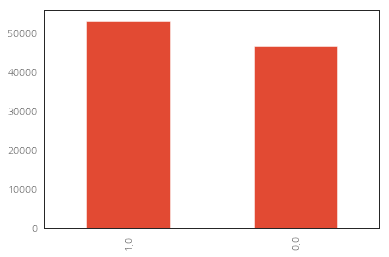

In [17]:
df_data['치석'].value_counts().plot(kind='bar') 
plt.show()

### 3-6. 명목형 변수 EDA

#### 3-6-1. 명목형 변수 추출 및 확인

In [18]:
# 앞에서 명목형 변수의 형을 object로 모두 변경했기 때문에 컬럼 중에서 object 타입을 가진 컬럼만 뽑아서 명목형 변수의 리스트를 만든다
# 이 때, 데이터의 기본키(인덱스), 종속변수 등을 제외하고 분석하는 것이 좋음

# 단변수 탐색
category_features = [col for col in df_data.columns if df_data[col].dtypes == "object"]
print(category_features)

cat_cols = list(set(category_features) - set(['치석']))
print(cat_cols)

['성별코드', '연령대코드5세단위', '시도코드', '신장5Cm단위', '체중5Kg단위', '청력좌', '청력우', '요단백', '흡연상태', '음주여부']
['성별코드', '청력좌', '음주여부', '연령대코드5세단위', '요단백', '흡연상태', '신장5Cm단위', '체중5Kg단위', '청력우', '시도코드']


#### 3-6-2. 명목형 변수 count plot (단변량)

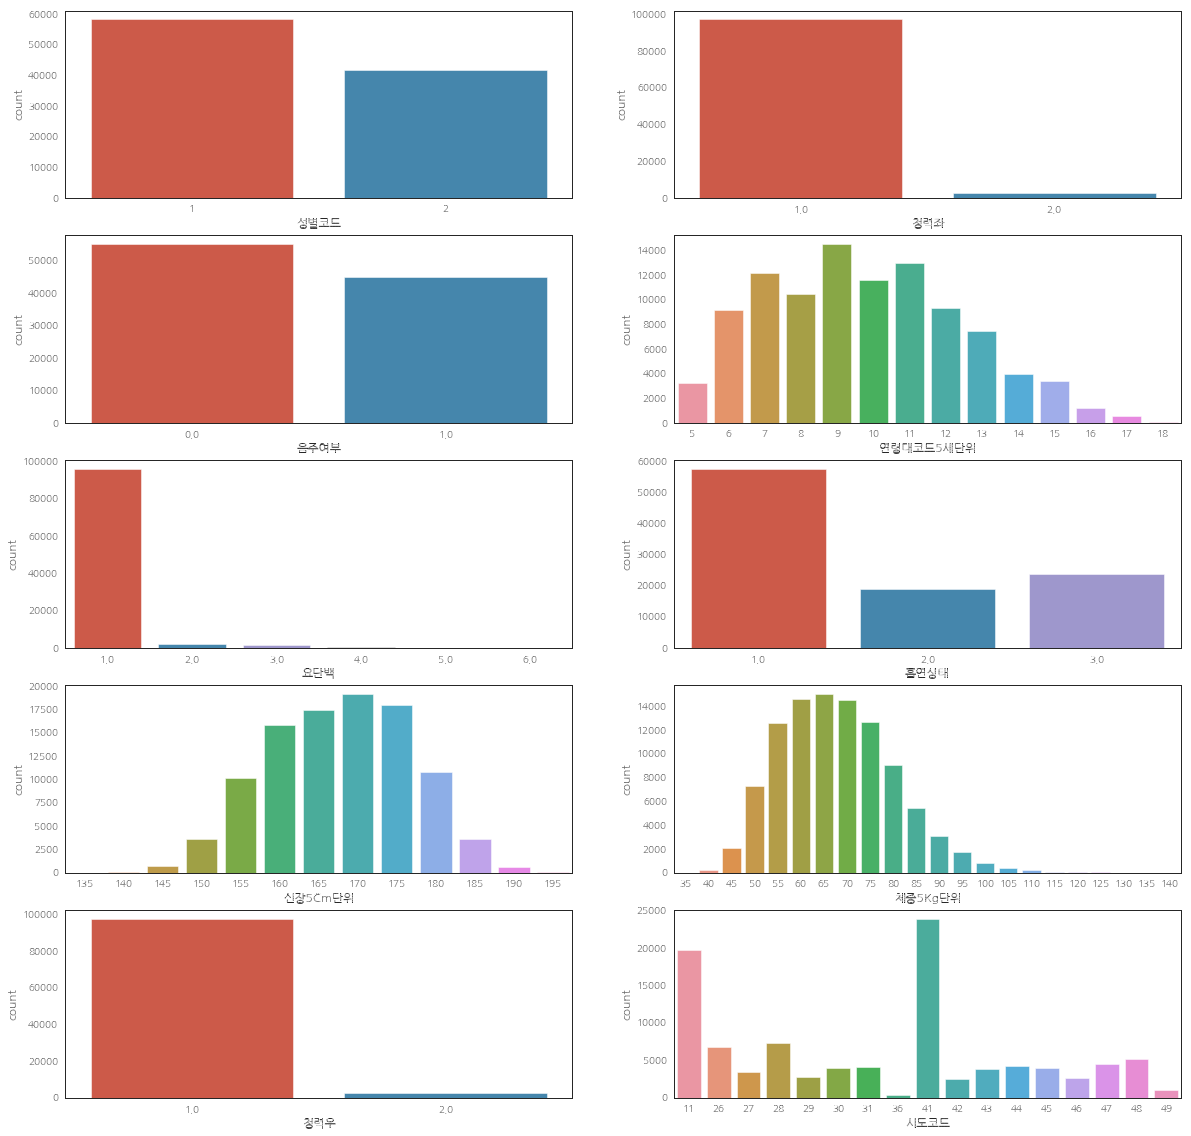

<Figure size 432x288 with 0 Axes>

In [19]:
# 그래프를 통해 명목형 변수의 분포를 체크

fig, saxis = plt.subplots(5, 2, figsize=(20,20))
plt.figure()

# 변수별로 for문을 돌면서 countplot을 그림
for idx, col in enumerate(cat_cols):
  row_loc = idx // 2
  col_loc = idx % 2
  sns.countplot(x=df_data[col], data= df_data, ax = saxis[row_loc,col_loc])
#   df_data[col].value_counts().plot(kind='bar', ax = saxis[row_loc,col_loc])
  
plt.show()

In [0]:
# # 단변수 Correlation Check

# def portion_func(x):
#     sum_val = np.sum(x)
#     cnt_val = len(x)
#     portion_val = sum_val/cnt_val
#     return portion_val
  
# for col in category_features:
#     if df_data[col].dtype == 'object':
#         print('치석 Correlation by:', col)
#         print(df_data[[col, '치석']].groupby(col).agg(['sum', 'count']))

# 이변수 탐색
# Simple Plotting
# categorical values

# fig, saxis = plt.subplots(1, 4, figsize=(20,4))

# plt.figure()

# sns.barplot(x='성별코드', y='치석', data=df_data, ax = saxis[0])
# sns.barplot(x='시도코드',y='치석', data=df_data, ax = saxis[1])
# sns.barplot(x='흡연상태',y='치석', data=df_data, ax = saxis[2])
# sns.barplot(x='흡연상태',y='치석', hue='성별코드', data=df_data, ax = saxis[3])

# plt.show()

#### 3-6-2. 명목형 변수 bar plot(이변량 - "치석" 종속변수와의 관계)

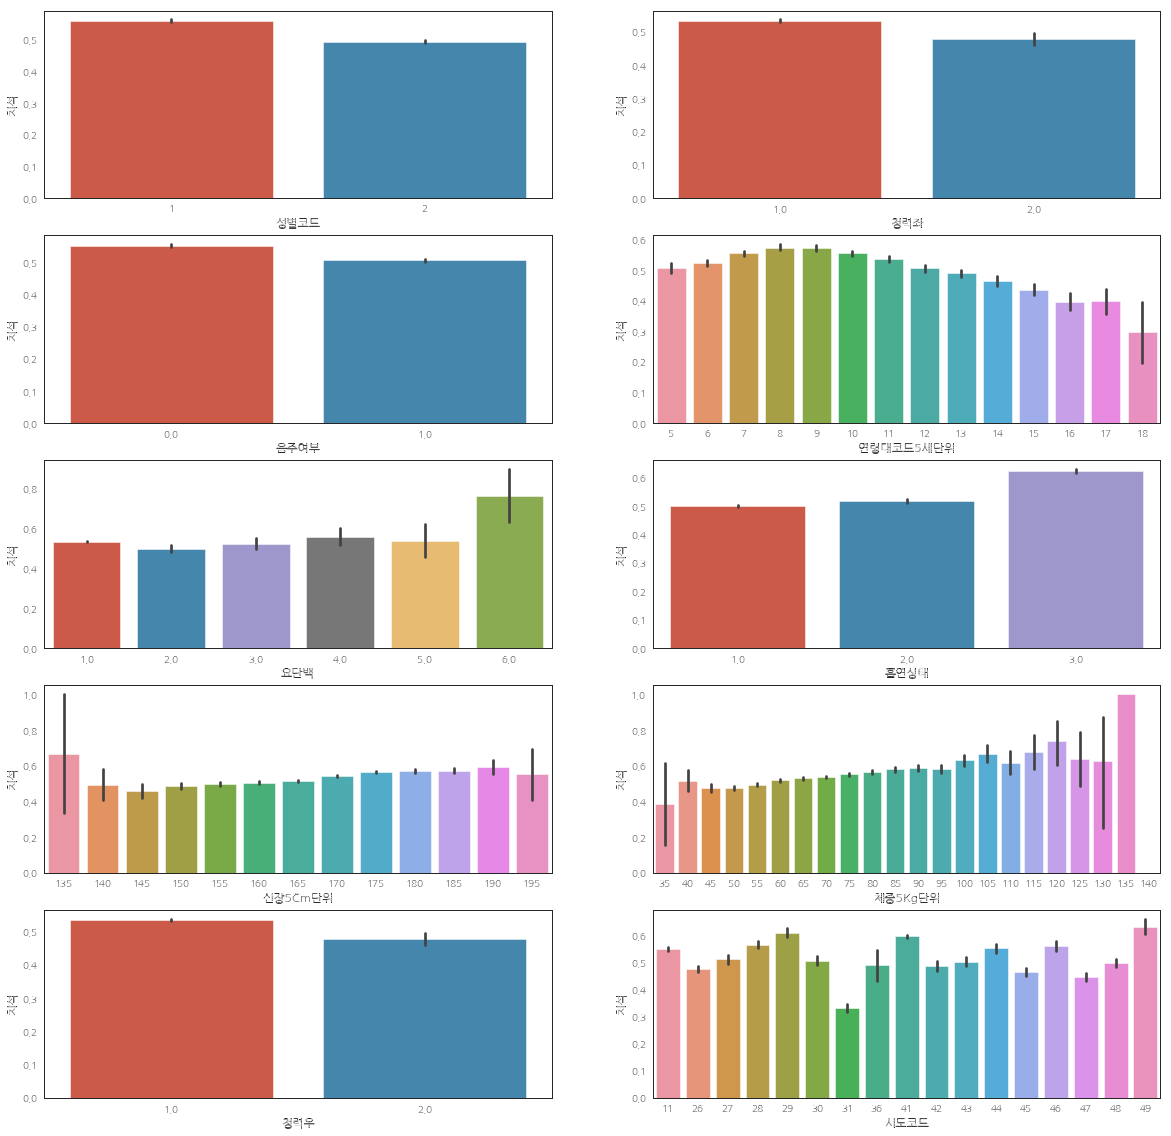

<Figure size 432x288 with 0 Axes>

In [21]:
fig, saxis = plt.subplots(5, 2, figsize=(20,20))
plt.figure()

# 변수별로 for문을 돌면서 barplot 그림
for idx, col in enumerate(cat_cols):
  row_loc = idx // 2
  col_loc = idx % 2
  sns.barplot(x=col, y='치석', data= df_data, ax = saxis[row_loc,col_loc])
  
plt.show()

### 3-7. 수치형 변수 EDA



#### 3-7-2. 수치형 변수 추출 및 확인

In [22]:
# 앞에서 명목형 변수의 형을 object로 모두 변경했기 때문에 컬럼 중에서 object 타입을 가진 컬럼만 뽑아서 명목형 변수의 리스트를 만든다
# 이 때, 데이터의 기본키(인덱스), 종속변수 등을 제외하고 분석하는 것이 좋음

# 단변수 탐색
numeric_features = [col for col in df_data.columns if df_data[col].dtypes != "object"]
numeric_features = np.sort(numeric_features)

num_cols = list(set(numeric_features) - set(['치석']))
print(num_cols)

print(len(num_cols)) # 총 15개

['혈청지오티AST', '이완기혈압', '감마지티피', '트리글리세라이드', '혈청크레아티닌', '혈색소', '시력우', '시력좌', 'LDL콜레스테롤', '허리둘레', '총콜레스테롤', '혈청지오티ALT', '수축기혈압', '식전혈당공복혈당', 'HDL콜레스테롤']
15


#### 3-7-3. 수치형 변수 count plot (단변량)

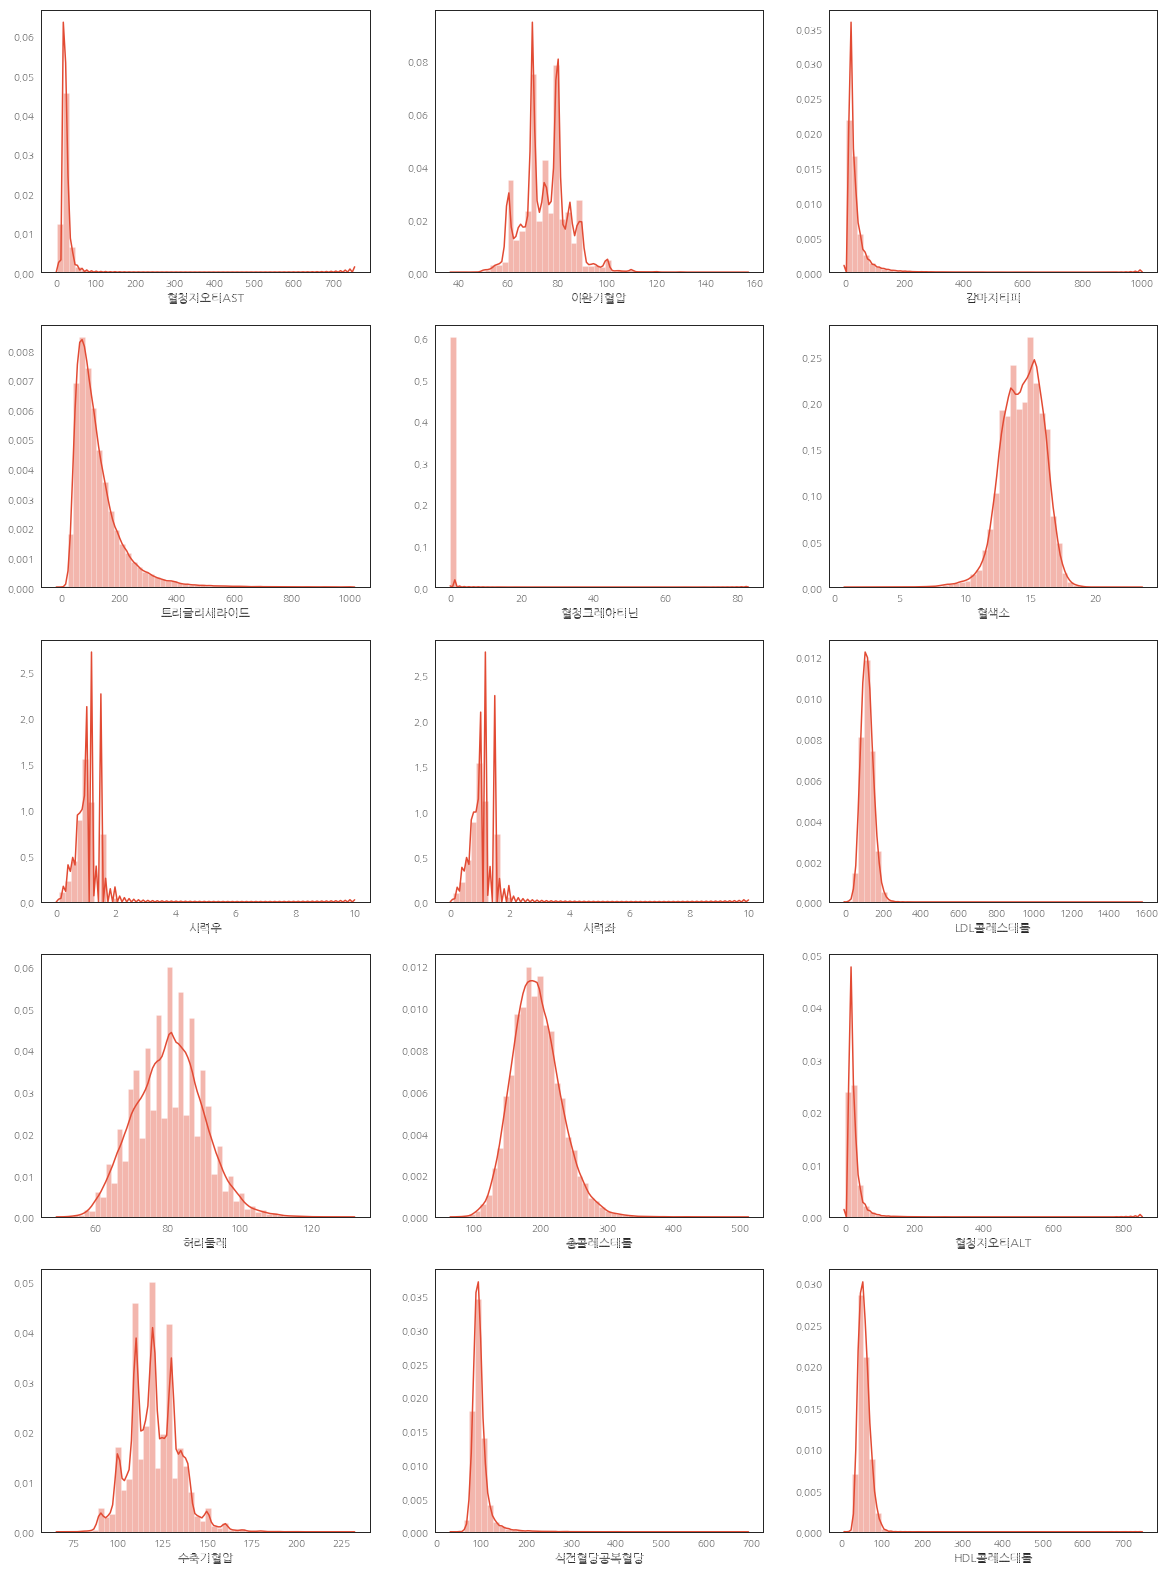

<Figure size 432x288 with 0 Axes>

In [23]:
# 단변수 탐색 - 단변수 탐색은 seaborn 패키지의 distplot 함수를 이용하면 편함
# 수치형 변수만 골라냄
fig, saxis = plt.subplots(5, 3, figsize=(20,28))
plt.figure()

# 변수별로 for문을 돌면서 distplot을 그림
for idx, col in enumerate(num_cols):
    row_loc = idx // 3
    col_loc = idx % 3
    sns.distplot(df_data.loc[df_data[col].notnull(), col], ax = saxis[row_loc,col_loc])

plt.show()

#### 3-7-4. 수치형 변수 Transformations 

In [24]:
# 수치형 변수들에 log를 취한 값 산출

# Feature Engineering의 일환으로 Log 값 취한 뒤 Normalization을 하여 변수명 + LN (lognorm)으로 열 추가 후 그래프 다시 그림
num_ln_cols = list(map(lambda x: str(x)+"_LN", num_cols))

num_pipeline = Pipeline([
        ('log_scaler', FunctionTransformer(np.log1p, validate=True)), # pipeline 내 log transformation을 위해 Function Transfomer 사용
        ('normalizer', MinMaxScaler()),
    ])

piped_np = num_pipeline.fit_transform(df_data[num_cols])
piped_df = pd.DataFrame(piped_np, columns=num_ln_cols)

print(len(piped_df))
piped_df.head()

100000


,혈청지오티AST_LN,이완기혈압_LN,감마지티피_LN,트리글리세라이드_LN,혈청크레아티닌_LN,혈색소_LN,시력우_LN,시력좌_LN,LDL콜레스테롤_LN,허리둘레_LN,총콜레스테롤_LN,혈청지오티ALT_LN,수축기혈압_LN,식전혈당공복혈당_LN,HDL콜레스테롤_LN
0,0.302885,0.310067,0.288314,0.469502,0.086424,0.770100,0.260671,0.214731,0.545771,0.356835,0.362746,0.309162,0.292466,0.282579,0.439000
1,0.397560,0.527445,0.412729,0.637339,0.137893,0.844258,0.302229,0.357967,0.628601,0.565115,0.540209,0.481923,0.496572,0.321062,0.398445
2,0.390731,0.665875,0.562627,0.678966,0.137893,0.834068,0.357967,0.357967,0.648778,0.577708,0.574319,0.477397,0.585871,0.358880,0.368486
3,0.368548,0.587635,0.393001,0.634245,0.159877,0.812911,0.260671,0.189809,0.583915,0.673641,0.498353,0.423648,0.597899,0.362117,0.467693
4,0.352087,0.421609,0.511384,0.469502,0.113591,0.773095,0.357967,0.357967,0.586946,0.156682,0.506455,0.353471,0.455245,0.362117,0.503831


#### 3-7-5. 로그 취한 수치형 변수 Concat을 통한 새 Dataframe 생성 

In [25]:
print("Before Re-indexing: Data count is ", len(df_data))
df_data.drop_duplicates()
df_data.reset_index(inplace=True, drop=True)
print("After Re-indexing: Data count is ", len(df_data))

df_fe = pd.concat([df_data, piped_df], axis=1)
df_fe.head()

Before Re-indexing: Data count is  100000
After Re-indexing: Data count is  100000


,성별코드,연령대코드5세단위,시도코드,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,청력좌,청력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,흡연상태,음주여부,치석,혈청지오티AST_LN,이완기혈압_LN,감마지티피_LN,트리글리세라이드_LN,혈청크레아티닌_LN,혈색소_LN,시력우_LN,시력좌_LN,LDL콜레스테롤_LN,허리둘레_LN,총콜레스테롤_LN,혈청지오티ALT_LN,수축기혈압_LN,식전혈당공복혈당_LN,HDL콜레스테롤_LN
0,2,6,49,160,50,72,0.8,1.0,1,1,99,60,82,151,36,69,75.0,12.9,1,0.6,15,12,11,1,1,1.0,0.302885,0.310067,0.288314,0.469502,0.086424,0.770100,0.260671,0.214731,0.545771,0.356835,0.362746,0.309162,0.292466,0.282579,0.439000
1,1,9,30,180,80,87,1.5,1.2,1,1,126,81,92,211,104,58,131.0,15.6,1,1.0,26,36,25,1,0,1.0,0.397560,0.527445,0.412729,0.637339,0.137893,0.844258,0.302229,0.357967,0.628601,0.565115,0.540209,0.481923,0.496572,0.321062,0.398445
2,1,9,41,170,75,88,1.5,1.5,1,1,140,98,103,225,135,51,150.0,15.2,1,1.0,25,35,65,3,0,0.0,0.390731,0.665875,0.562627,0.678966,0.137893,0.834068,0.357967,0.357967,0.648778,0.577708,0.574319,0.477397,0.585871,0.358880,0.368486
3,1,10,11,175,80,96,0.7,1.0,1,1,142,88,104,195,102,78,97.0,14.4,1,1.2,22,25,22,3,0,1.0,0.368548,0.587635,0.393001,0.634245,0.159877,0.812911,0.260671,0.189809,0.583915,0.673641,0.498353,0.423648,0.597899,0.362117,0.467693
4,2,9,41,165,40,60,1.5,1.5,1,1,120,70,104,198,36,91,99.0,13.0,1,0.8,20,16,47,1,0,1.0,0.352087,0.421609,0.511384,0.469502,0.113591,0.773095,0.357967,0.357967,0.586946,0.156682,0.506455,0.353471,0.455245,0.362117,0.503831


#### 3-7-6. 수치형 LN 변수 count plot (단변량)

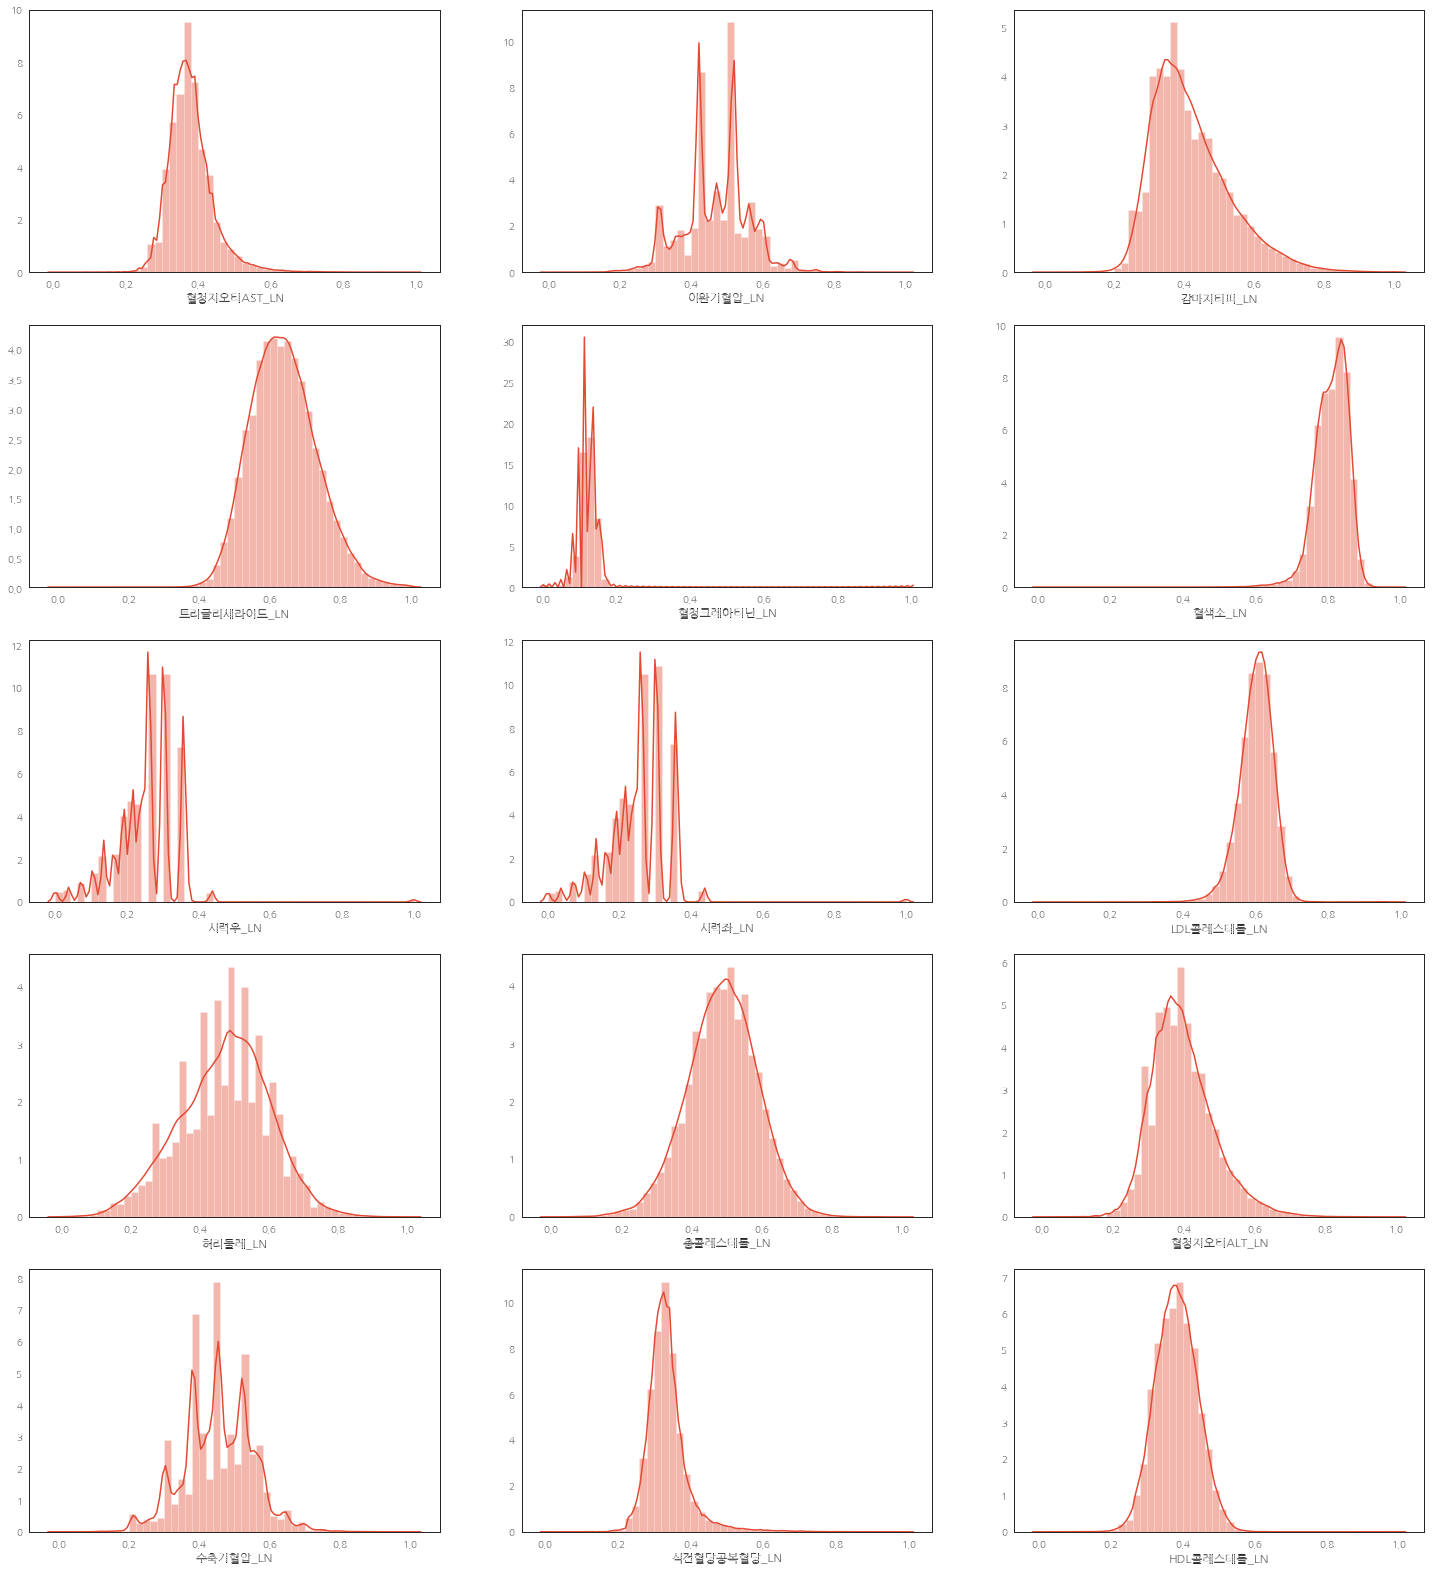

<Figure size 432x288 with 0 Axes>

In [26]:
# 단변수 탐색 with log 변형 변수
# 수치형 변수만 골라냄
fig, saxis = plt.subplots(5, 3, figsize=(25,28))
plt.figure()

# 변수별로 for문을 돌면서 distplot 그림
for idx, col in enumerate(num_ln_cols):
    row_loc = idx // 3
    col_loc = idx % 3
#     print(idx, row_loc, col_loc)
    sns.distplot(df_fe.loc[df_fe[col].notnull(), col], ax = saxis[row_loc,col_loc])

plt.show()

### 3-8. Information Value 계산을 위한 환경 세팅

### 3-8-1. woe library 설치

In [27]:
# woe package install
! pip install woe

### 3-8-2. Library Load 및 환경 변수 세팅

In [0]:
# Calculate IV Setting
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import string
import woe
from woe.eval import plot_ks

max_bin = 10
force_bin = 3

### 3-8-3. Information Value 산출 사용자 정의 함수 정의

In [0]:
# Define a binning function for continous independent variables
def mono_bin(Y, X, n = max_bin):
  df1 = pd.DataFrame({"X": X, "Y": Y})
  justmiss = df1[['X','Y']][df1.X.isnull()]
  notmiss = df1[['X','Y']][df1.X.notnull()]
  r = 0
    
  while np.abs(r) < 1:
    try:
      global d1
      global d2
      d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
      d2 = d1.groupby('Bucket', as_index=True)
      r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
      n = n - 1 
    except Exception as e:
      n = n - 1
      break
      
  if len(d2) == 1:
    n = force_bin         
    bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
    if len(np.unique(bins)) == 2:
        bins = np.insert(bins, 0, 1)
        bins[1] = bins[1]-(bins[1]/2)
    d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
    d2 = d1.groupby('Bucket', as_index=True)

  d3 = pd.DataFrame({},index=[])
  d3["MIN_VALUE"] = d2.min().X
  d3["MAX_VALUE"] = d2.max().X
  d3["COUNT"] = d2.count().Y
  d3["EVENT"] = d2.sum().Y
  d3["NONEVENT"] = d2.count().Y - d2.sum().Y
  d3=d3.reset_index(drop=True)

  if len(justmiss.index) > 0:
      d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
      d4["MAX_VALUE"] = np.nan
      d4["COUNT"] = justmiss.count().Y
      d4["EVENT"] = justmiss.sum().Y
      d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
      d3 = d3.append(d4,ignore_index=True)

  d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
  d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
  d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
  d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
  d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["VAR_NAME"] = "VAR"
  d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
  d3 = d3.replace([np.inf, -np.inf], 0)
  d3.IV = d3.IV.sum()

  return(d3)
  
# Define a binning function for categorical independent variables
def char_bin(Y, X):
  df1 = pd.DataFrame({"X": X, "Y": Y})
  justmiss = df1[['X','Y']][df1.X.isnull()]
  notmiss = df1[['X','Y']][df1.X.notnull()]    
  df2 = notmiss.groupby('X',as_index=True)

  d3 = pd.DataFrame({},index=[])
  d3["COUNT"] = df2.count().Y
  d3["MIN_VALUE"] = df2.sum().Y.index
  d3["MAX_VALUE"] = d3["MIN_VALUE"]
  d3["EVENT"] = df2.sum().Y
  d3["NONEVENT"] = df2.count().Y - df2.sum().Y

  if len(justmiss.index) > 0:
    d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
    d4["MAX_VALUE"] = np.nan
    d4["COUNT"] = justmiss.count().Y
    d4["EVENT"] = justmiss.sum().Y
    d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
    d3 = d3.append(d4,ignore_index=True)

  d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
  d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
  d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
  d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
  d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["VAR_NAME"] = "VAR"
  d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
  d3 = d3.replace([np.inf, -np.inf], 0)
  d3.IV = d3.IV.sum()
  d3 = d3.reset_index(drop=True)

  return(d3)

# Calculate Information Values
def calc_iv_all(df1, target):
    
  stack = traceback.extract_stack()
  filename, lineno, function_name, code = stack[-2]
  vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
  final = (re.findall(r"[\w']+", vars_name))[-1]

  x = df1.dtypes.index
  count = -1

  for i in tqdm_notebook(x):
    if i.upper() not in (final.upper()):
      if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
        conv = mono_bin(target, df1[i])
        conv["VAR_NAME"] = i
        count = count + 1
      else:
        conv = char_bin(target, df1[i])
        conv["VAR_NAME"] = i            
        count = count + 1

      if count == 0:
        iv_df = conv
      else:
        iv_df = iv_df.append(conv,ignore_index=True)

  iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
  iv = iv.reset_index()
  return(iv_df,iv)

### 3-8-4. IV 산출을 위한 data sampling 및 IV 산출

In [0]:
# Data Sampling으로 몇 개 추려서 Information Value Test
# df_sample = df_fe.sample(100).copy()
# # display(df_sample.head())
# # display(df_sample.info())

In [31]:
# IV 산출
first_iv_df, IV_first = calc_iv_all(df_fe,df_fe['치석'])
first_iv_df

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,성별코드,1.000000,1.000000,58255,32629.0,0.560106,25626.0,0.439894,0.613097,0.547798,0.112615,0.017537
1,성별코드,2.000000,2.000000,41745,20591.0,0.493257,21154.0,0.506743,0.386903,0.452202,-0.155953,0.017537
2,연령대코드5세단위,5.000000,5.000000,3197,1617.0,0.505787,1580.0,0.494213,0.030383,0.033775,-0.105831,0.026366
3,연령대코드5세단위,6.000000,6.000000,9155,4791.0,0.523321,4364.0,0.476679,0.090023,0.093288,-0.035628,0.026366
4,연령대코드5세단위,7.000000,7.000000,12150,6740.0,0.554733,5410.0,0.445267,0.126644,0.115648,0.090832,0.026366
5,연령대코드5세단위,8.000000,8.000000,10461,5998.0,0.573368,4463.0,0.426632,0.112702,0.095404,0.166626,0.026366
6,연령대코드5세단위,9.000000,9.000000,14469,8275.0,0.571912,6194.0,0.428088,0.155487,0.132407,0.160679,0.026366
7,연령대코드5세단위,10.000000,10.000000,11622,6445.0,0.554552,5177.0,0.445448,0.121101,0.110667,0.090100,0.026366
8,연령대코드5세단위,11.000000,11.000000,12954,6945.0,0.536128,6009.0,0.463872,0.130496,0.128452,0.015785,0.026366
9,연령대코드5세단위,12.000000,12.000000,9345,4724.0,0.505511,4621.0,0.494489,0.088764,0.098782,-0.106934,0.026366


In [32]:
# IV 값 내림차순 정렬
IV_first.sort_values('IV',ascending=False)

,VAR_NAME,IV
9,시도코드,0.064910
39,흡연상태,0.042423
17,연령대코드5세단위,0.026366
31,혈색소,0.022657
32,혈색소_LN,0.022657
13,시력좌_LN,0.022657
11,시력우_LN,0.022657
37,혈청크레아티닌,0.022657
24,체중5Kg단위,0.018384
6,성별코드,0.017537


## 4. Feature Engineering

### 4-1. Feature Engineering 변수 추가

#### 4-1-1. 데이터셋 내 내부 변수의 범주화를 통한 신규 변수 추출

In [0]:
# 기존 수치형 변수들을 LN 변수들로 치환
# df_fe.drop(columns=numeric_feature, axis=1, inplace=True)

# BMI 변수 추가
df_fe["A_BMI"] = (df_fe["체중5Kg단위"]/(df_fe["신장5Cm단위"]*df_fe["신장5Cm단위"])).astype(float)

# 공복 혈당 
# 100 이하는 정상/ 100 ~ 125는 '공복혈당장애 - 당뇨 전단계'/ 125 이상은 당뇨
# 당뇨병의 중간인 100~125 mg/dL가 나오거나 

df_fe["A_diabetes"] = np.where(df_fe['식전혈당공복혈당'].between(0, 100, inclusive=True), '정상', 
                               np.where(df_fe['식전혈당공복혈당'].between(100, 124.9, inclusive=True), '당뇨전단계', 
                                        '당뇨')
                              )

# HDL 콜레스테롤
# HDL 콜레스테롤 수치가 남자에서 40 mg/dL (1.0 mmol/L) 이하 또는 여자에서 50 mg/dL (1.3 mmol/L) 이하일 경우에는 다른 위험인자와 독립적으로 심장 질환의 위험도가 증가
# HDL 콜레스테롤 수치가 남자에서 40-50 mg/dL (1.0-1.3 mmol/L) 그리고 여자에서 50-59 mg/dL (1.3-1.5 mmol/L)인 경우에는 심장 질환의 평균위험도와 연관
# 보통 HDL 콜레스테롤 수치가 60 mg/dL (1.55 mmol/L) 또는 그 이상일 경우에는 심장 질환 평균 위험도보다 낮음
# National Cholesterol Education Panel Adult Treatment Guidelines에 따르면 HDL 콜레스테롤 수치가 60 mg/dL 이상일 경우 심장 질환에서 보호되고 음성 위험 인자로서 치료되어야 함
df_fe["A_HDL"] = np.where(
                    (df_fe['성별코드'].astype('int') == 2) & (df_fe['HDL콜레스테롤']<= 50), '고위험', 
                       np.where(
                         (df_fe['성별코드'].astype('int') == 2) & (df_fe['HDL콜레스테롤'].between(50, 59.9, inclusive=True)), '위험', 
                           np.where(
                               (df_fe['성별코드'].astype('int') == 1) & (df_fe['HDL콜레스테롤']<= 40), '고위험', 
                                      np.where(
                                          (df_fe['성별코드'].astype('int') == 1) & (df_fe['HDL콜레스테롤'].between(40, 49.9, inclusive=True)), '위험', '정상')
                          )))
# LDL 콜레스테롤(혈중 모든 콜레스테롤 중 LDL 콜레스테롤이 심장질환에 대한 위험도를 확인하는데 가장 중요한 지표)
# 대부분의 치료 결정이 LDL 수치를 토대로 이루어지기 때문에 이 검사를 통해 식이요법 또는 운동처방의 효과를 감시하거나 지질감소 약물을 처방하는 것이 유용한지에 대한 평가
# 100 mg/dL (2.59mmol/L) 미만 – 최적
# 100-129 mg/dL (2.59-3.34 mmol/L) – 최적에 인접
# 130-159 mg/dL (3.37-4.12 mmol/L) – 상한 경계성
# 160-189 mg/dL (4.15-4.90 mmol/L) – 높음
# 190 mg/dL (4.90 mmol) 이상 – 매우 높음
df_fe["A_LDL"] = np.where(df_fe['LDL콜레스테롤']<100, '최적', 
                    np.where(df_fe['LDL콜레스테롤'].between(100, 122.9, inclusive=True), '최적인접', 
                             np.where(df_fe['LDL콜레스테롤'].between(130, 159.9, inclusive=True), '상한경계', 
                                      np.where(df_fe['LDL콜레스테롤'].between(160, 189.9, inclusive=True), '높음', '매우높음')
                              )))

# 트리글리세라이드
# 지방의 한 형태로서 몸의 주요 에너지원, 트리글리세라이드가 증가하는 것은, 이유가 분명하지 않으나 심혈관 질환으로 진행될 위험의 증가와 관련
# 일부 인자들 즉, 운동 부족, 과체중, 흡연, 과음 및 당뇨와 신질환 등의 질병 상태가 고트리글리세라이드혈증 및 심혈관 질환 위험도 증가에 기여할 수 있음
# 성인에서는 트리글리세라이드 결과가 아래와 같이 나뉘어진다.
# 150 mg/dL (1.7 mmol/L) 미만: 바람직
# 150-199 mg/dL (1.7-2.2 mmol/L): 경계성증가
# 200-499 mg/dL (2.3-5.6 mmol/L): 증가: 
# 500 mg/dL (5.6 mmol/L) 이상: 매우 증가
# 이 수치는 공복시 트리글리세라이드 수치에 기준합니다.
df_fe["A_TRI"] = np.where(df_fe['트리글리세라이드']<150, '바람직', 
                    np.where(df_fe['트리글리세라이드'].between(150, 199.9, inclusive=True), '경계성증가', 
                             np.where(df_fe['트리글리세라이드'].between(200, 499.9, inclusive=True), '증가', '매우증가')
                              ))

# 혈색소
# 성인의 데시리터(100밀리리터) 당 12그램에서 18그램 정도: 정상치
# 18그램 이상: 폐질환 등 기타 이상
# 12그램 미만: 빈혈
df_fe["A_HEMO"] = np.where(df_fe['혈색소'].between(12, 17.9, inclusive=True), '정상', 
                    np.where(df_fe['혈색소']>=18, '이상', '빈혈'))

# 요단백: 소변으로 빠져나가는 잉여의 단백질을 검출하기 위해, 신장 기증을 평가하고 모니터하는 것을 돕기 위해,  그리고 신장 손상을 검출하기 위해 검사
# 요단백은 보통 소변에서 검출 되지 않음- 검출 되면 
df_fe["A_PIU"] = np.where(df_fe['요단백']==1, '정상', '이상')

# 혈중 크레아티닌 농도의 
# 정상범위는 0.50~1.4 mg/dL 입니다
# 근육량에 비례하는 검사결과이므로 여성보다는 남성에게서 약간 높은 수치가 나타나고, 식사나 운동이 결과에 영향이 거의 미치지 않습니다. 지속적으로 많은 양의 육식을 섭취한 경우에는 크레아티닌 농도가 높게 측정됩니다.
df_fe["A_CRE"] = np.where(df_fe['혈청크레아티닌'].between(0.5, 1.4, inclusive=True), '정상', '이상')

# 혈청지오티AST:
#  간기능을 평가하는 기초검사항목으로서 알코올성 간장애나 만성 간질환에서 주로 증가한다.
 

# 혈청지오티ALT:
# 간기능을 평가하는 기초검사항목으로서 급성 간염 시 주로 증가한다.
# 증가: 간질환, 심근경색, 지방간, 비만


# 감마지티피
# 간장세포나 담낭세포가 파괴되면 감마지티피가 혈액속으로 누출되어 수치가 높아짐
# 남자는 50IU 이하, 여자는 32IU이하가 정상
# 100이하면 음주 조절을 통해 조정 가능하나 100 이상이면 지방간이 진행되고 있을 가능성이 높음
# 200 이상이면 담석이나 담도암등으로 담도가 막혀있을 가능성이 높음
# 500 이상이면 황달
df_fe["A_GTP"] = np.where((df_fe['감마지티피'] >= 500), '황달', 
                       np.where(df_fe['감마지티피']>=200, '담도이상', 
                           np.where(df_fe['감마지티피']>= 100, '이상가능', 
                             np.where((df_fe['성별코드'].astype('int') == 1) & (df_fe['감마지티피']<=50), '정상',
                              np.where((df_fe['성별코드'].astype('int') == 2) & (df_fe['감마지티피']<=32), '정상', '체크')
                          ))))

#### 4-1-2. 데이터셋 내 내부 변수 신규 변수 검증

In [34]:
display(df_fe.info())
df_fe.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 50 columns):
성별코드           100000 non-null object
연령대코드5세단위      100000 non-null object
시도코드           100000 non-null object
신장5Cm단위        100000 non-null object
체중5Kg단위        100000 non-null object
허리둘레           100000 non-null int64
시력좌            100000 non-null float64
시력우            100000 non-null float64
청력좌            100000 non-null object
청력우            100000 non-null object
수축기혈압          100000 non-null int64
이완기혈압          100000 non-null int64
식전혈당공복혈당       100000 non-null int64
총콜레스테롤         100000 non-null int64
트리글리세라이드       100000 non-null int64
HDL콜레스테롤       100000 non-null int64
LDL콜레스테롤       100000 non-null float64
혈색소            100000 non-null float64
요단백            100000 non-null object
혈청크레아티닌        100000 non-null float64
혈청지오티AST       100000 non-null int64
혈청지오티ALT       100000 non-null int64
감마지티피          100000 non-null int64
흡연상태           100000

None

,성별코드,연령대코드5세단위,시도코드,신장5Cm단위,체중5Kg단위,허리둘레,시력좌,시력우,청력좌,청력우,수축기혈압,이완기혈압,식전혈당공복혈당,총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,혈청지오티AST,혈청지오티ALT,감마지티피,흡연상태,음주여부,치석,혈청지오티AST_LN,이완기혈압_LN,감마지티피_LN,트리글리세라이드_LN,혈청크레아티닌_LN,혈색소_LN,시력우_LN,시력좌_LN,LDL콜레스테롤_LN,허리둘레_LN,총콜레스테롤_LN,혈청지오티ALT_LN,수축기혈압_LN,식전혈당공복혈당_LN,HDL콜레스테롤_LN,A_BMI,A_diabetes,A_HDL,A_LDL,A_TRI,A_HEMO,A_PIU,A_CRE,A_GTP
34586,1,12,28,165,60,81,1.2,1.5,1,1,125,85,101,204,121,51,128.0,13.5,1,1.2,43,44,21,2,1,1.0,0.485921,0.562440,0.385848,0.661486,0.159877,0.787755,0.357967,0.302229,0.625152,0.486410,0.522300,0.514253,0.489822,0.352311,0.368486,0.002204,당뇨전단계,정상,매우높음,바람직,정상,정상,정상,정상
28230,1,11,45,170,70,81,0.8,1.0,1,1,132,88,102,214,124,42,147.0,14.3,1,1.1,25,32,56,2,0,0.0,0.390731,0.587635,0.539037,0.665395,0.149147,0.810190,0.260671,0.214731,0.645767,0.486410,0.547704,0.463026,0.535992,0.355611,0.323404,0.002422,당뇨전단계,위험,상한경계,바람직,정상,정상,정상,체크
55533,1,11,30,170,60,70,1.2,1.0,2,2,101,75,98,171,60,60,98.0,16.1,1,0.7,29,22,9,2,0,0.0,0.416623,0.471613,0.258977,0.549950,0.100408,0.856655,0.260671,0.302229,0.585438,0.325874,0.428681,0.403398,0.309377,0.342212,0.406353,0.002076,정상,정상,최적,바람직,정상,정상,정상,정상
59899,2,6,11,170,65,66,0.5,0.3,1,1,95,52,92,142,52,61,70.0,12.7,1,0.7,14,8,10,1,0,1.0,0.291207,0.206772,0.274313,0.527329,0.100408,0.764046,0.072840,0.135235,0.535560,0.261246,0.330190,0.248426,0.257607,0.321062,0.410211,0.002249,정상,정상,최적,바람직,정상,정상,정상,정상
49706,1,6,45,180,70,76,0.2,0.2,1,1,98,68,91,198,152,55,113.0,15.9,1,1.0,23,22,32,3,0,1.0,0.376248,0.400615,0.451092,0.697919,0.137893,0.851740,0.037939,0.037939,0.606605,0.416290,0.506455,0.403398,0.283884,0.317405,0.386066,0.002160,정상,정상,최적인접,경계성증가,정상,정상,정상,정상


#### 4-1-3. 데이터셋 외부 변수를 통한 신규 변수 추출 (To-Do)

#### 4-1-4. 데이터셋 내 내부 변수 신규 변수 검증(To-Do)

### 4-2. FE 추가변수 IV값 산출

In [35]:
fe_iv_df, IV_fe = calc_iv_all(df_fe,df_fe['치석'])
# fe_iv_df

In [36]:
# IV 값 내림차순 정렬
IV_fe.sort_values('IV',ascending=False)

,VAR_NAME,IV
18,시도코드,0.064910
48,흡연상태,0.042423
26,연령대코드5세단위,0.026366
46,혈청크레아티닌,0.022657
22,시력좌_LN,0.022657
41,혈색소_LN,0.022657
20,시력우_LN,0.022657
40,혈색소,0.022657
33,체중5Kg단위,0.018384
15,성별코드,0.017537


### 4-3. Feature Engineering 이전과 Feature Engineering 이후의 IV 값 비교

In [37]:
IV_compare = pd.merge(IV_fe, IV_first, how='outer', on="VAR_NAME")
IV_compare = IV_compare.reset_index(drop=True)
IV_compare.sort_values(['IV_x'], ascending=False)

,VAR_NAME,IV_x,IV_y
18,시도코드,0.064910,0.064910
48,흡연상태,0.042423,0.042423
26,연령대코드5세단위,0.026366,0.026366
46,혈청크레아티닌,0.022657,0.022657
22,시력좌_LN,0.022657,0.022657
41,혈색소_LN,0.022657,0.022657
20,시력우_LN,0.022657,0.022657
40,혈색소,0.022657,0.022657
33,체중5Kg단위,0.018384,0.018384
15,성별코드,0.017537,0.017537


In [38]:
# Feature Engineering 이후 불필요컬럼 Dropt
df_final = df_fe[['시도코드','흡연상태','연령대코드5세단위','혈청크레아티닌','혈색소','감마지티피','체중5Kg단위','성별코드','신장5Cm단위','시력우','시력좌','허리둘레','트리글리세라이드','혈청지오티ALT','음주여부','A_GTP','A_BMI','A_TRI','이완기혈압','HDL콜레스테롤','수축기혈압','치석']].copy()
df_final.columns

Index(['시도코드', '흡연상태', '연령대코드5세단위', '혈청크레아티닌', '혈색소', '감마지티피', '체중5Kg단위',
       '성별코드', '신장5Cm단위', '시력우', '시력좌', '허리둘레', '트리글리세라이드', '혈청지오티ALT', '음주여부',
       'A_GTP', 'A_BMI', 'A_TRI', '이완기혈압', 'HDL콜레스테롤', '수축기혈압', '치석'],
      dtype='object')

In [39]:
# 상관계수 검증을 위한 연속형 변수 탐색
num_features_after_fe = [col for col in df_final.columns if df_final[col].dtypes != "object"]
num_features_after_fe = np.sort(num_features_after_fe)

num_input = list(set(num_features_after_fe) - set(['치석']))
print(num_input)

print(len(num_input)) # 총 16개

['시력우', 'A_BMI', '시력좌', '이완기혈압', '감마지티피', '트리글리세라이드', '허리둘레', '혈청크레아티닌', '혈색소', '혈청지오티ALT', '수축기혈압', 'HDL콜레스테롤']
12


In [40]:
from pprint import pprint as pp

corr_dict = {}

for i in num_input:
    corr_dict[i] = df_final['치석'].astype('float64').corr(df_final[i])

pp(corr_dict)

{'A_BMI': 0.04378289333715028,
 'HDL콜레스테롤': -0.02501272025770007,
 '감마지티피': 0.04006235206321582,
 '수축기혈압': 0.03153113585149091,
 '시력우': 0.01590672629552788,
 '시력좌': 0.015153766197904655,
 '이완기혈압': 0.03409015771712192,
 '트리글리세라이드': 0.052110735761203106,
 '허리둘레': 0.0568420354541417,
 '혈색소': 0.06836385714358158,
 '혈청지오티ALT': 0.03999201712755924,
 '혈청크레아티닌': 0.013423752245629327}


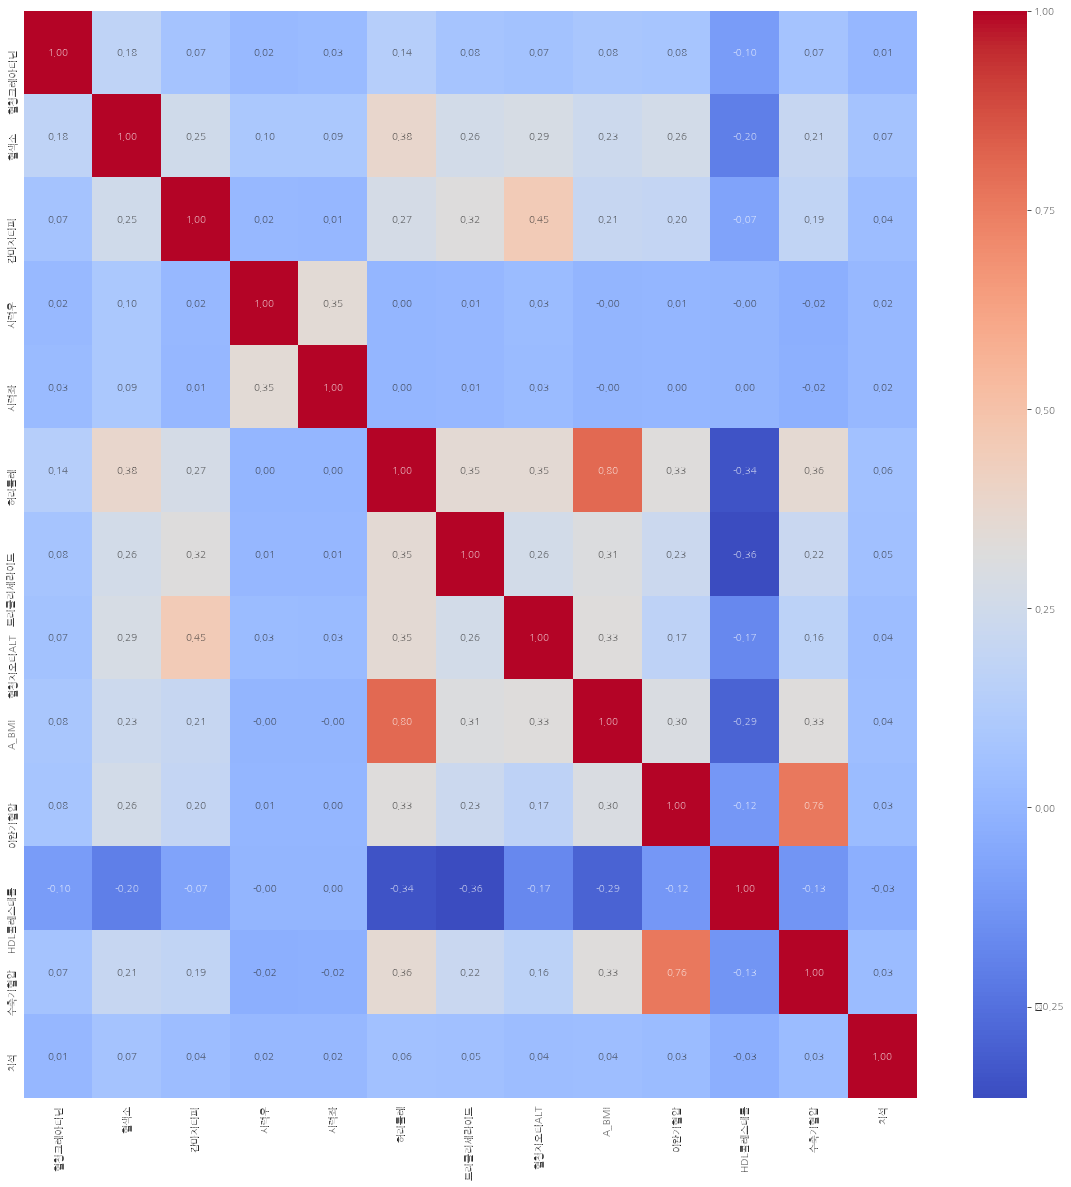

In [41]:
# 데이터 간의 상관관계 체크
# 수치형변수들과 Survived 변수의 상관관계 Matrix 시각화
plt.figure(figsize=(20, 20))
g = sns.heatmap(df_final.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

### 모델 입력 전 최종 모델 입력에 맞게 입력 데이터 변형

In [0]:
data_x = df_final[df_final.columns.difference(['치석'])]
data_y = df_final['치석'].astype('float64')

In [43]:
num_attribs = [col for col in data_x.columns if data_x[col].dtype in ['int64','float64']]
cat_attribs = [col for col in data_x.columns if data_x[col].dtype not in ['int64','float64']]

num_attribs = list(set(num_attribs) - set(['치석']))

print("num_attribs: ", num_attribs)
print("cat_attribs: ", cat_attribs)

num_attribs:  ['시력우', 'A_BMI', '시력좌', '이완기혈압', '감마지티피', '트리글리세라이드', '허리둘레', '혈청크레아티닌', '혈색소', '혈청지오티ALT', '수축기혈압', 'HDL콜레스테롤']
cat_attribs:  ['A_GTP', 'A_TRI', '성별코드', '시도코드', '신장5Cm단위', '연령대코드5세단위', '음주여부', '체중5Kg단위', '흡연상태']


### 수치형 변수 정규화 및 Pipeline 연결



In [0]:
# Feature Engineering의 일환으로 Log 값 취한 뒤 Normalization을 하여 변수명 + LN (lognorm)으로 열 추가 후 그래프 다시 그림
num_pipeline = Pipeline([
        ('min_max_scaler', MinMaxScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_attribs),
        ("cat_encoder", OneHotEncoder(sparse=False), cat_attribs),
    ])

data_x_piped = full_pipeline.fit_transform(data_x)

data_y_piped = data_y.values

### Train & Test 데이터 분리

In [0]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data_x_piped, data_y_piped, test_size = 0.3, random_state = 0)

In [46]:
display(train_x.shape)
display(test_x.shape)
display(train_y.shape)
display(test_y.shape)

(70000, 94)

(30000, 94)

(70000,)

(30000,)

In [0]:
#Machine Learning Algorithm (MLA) 선택 및 초기화

# 1차 Test 후 좋은 성능을 보인 모델 
# ['LogisticRegressionCV', 'RidgeClassifierCV', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'LinearDiscriminantAnalysis', 'XGBClassifier']
MLA = [ 
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),

    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
       
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),   

    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()
    ]

#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=.3, train_size =.6, random_state=0) # run model 10x with 60/30 split intentionally leaving out 10%

In [48]:
# 모델평가를 위한 변수 세팅
score_pram = ['accuracy', 'precision','recall','f1']

#Create Table to Compare Canonical Models
MLA_Result_columns = ['ModelName','Dataset','Accuracy','Precision','Recall','F1']
MLA_compare = pd.DataFrame(columns = MLA_Result_columns)

#create table to compare MLA predictions
MLA_predict = pd.DataFrame(train_y)
print(MLA_predict.shape)

(70000, 1)


In [49]:
#index through MLA and save performance to table
row_index = 0
cv = 3
# 알고리즘을 하나씩 꺼내면서 loop
for alg in tqdm_notebook(MLA):
    print(alg, "algorithm modeling starts ... ")
    #알고리즘의 이름은 할당하고, [row_index, MLA Name]에 이름을 넣고, [row_index, MLA Parameters]에 알고리즘의 파라미터들을 할당
    Model_Name = alg.__class__.__name__
    
    cv_results = cross_validate(alg, train_x, train_y, cv=cv, scoring=score_pram, return_train_score=True, n_jobs=-1, verbose=1)
    
    train_cnt = 0
    test_cnt = 0
    
    for i in cv_results.keys():
      if("train" in i and train_cnt == 0):
        MLA_compare.loc[row_index, 'ModelName'] = Model_Name
        MLA_compare.loc[row_index, 'Dataset'] = "TrainSet"
        MLA_compare.loc[row_index, 'Accuracy'] = format(cv_results['train_accuracy'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Precision'] = format(cv_results['train_precision'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Recall'] = format(cv_results['train_recall'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'F1'] = format(cv_results['train_f1'].mean(), "10.4f")
        row_index+=1
        train_cnt+=1
      elif("test" in i and test_cnt ==0):
        MLA_compare.loc[row_index, 'ModelName'] = Model_Name
        MLA_compare.loc[row_index, 'Dataset'] = "TestSet"
        MLA_compare.loc[row_index, 'Accuracy'] = format(cv_results['test_accuracy'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Precision'] = format(cv_results['test_precision'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Recall'] = format(cv_results['test_recall'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'F1'] = format(cv_results['test_f1'].mean(), "10.4f")
        row_index+=1
        test_cnt+=1

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   51.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), class_weight=None, cv=None,
                  fit_intercept=True, normalize=False, scoring=None,
                  store_cv_values=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


GaussianNB(priors=None, var_smoothing=1e-09) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform') algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


GaussianProcessClassifier(copy_X_train=True, kernel=None, max_iter_predict=100,
                          multi_class='one_vs_rest', n_jobs=None,
                          n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
                          random_state=None, warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 133.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


TerminatedWorkerError: ignored

In [0]:
    # print("After Cross Validatin .. Just model fitting for Prediction with ", alg)
    # alg.fit(train_x, train_y)
    # MLA_predict[Model_Name] = alg.predict(test_x)
    # print(alg, "model is finished...")

In [0]:
MLA_compare

In [0]:
# MLA_predict
['LogisticRegressionCV', 'RidgeClassifierCV', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'LinearDiscriminantAnalysis', 'XGBClassifier']

In [0]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
plt.figure(figsize=(8,6))
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, palette=sns.husl_palette(n_colors=20,l=.7))

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')
plt.show()

In [0]:
from sklearn import tree, linear_model, naive_bayes, ensemble

# evaluation package
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

In [0]:
model_lr = linear_model.LogisticRegression()
model_lr.fit(x_train, y_train)

In [0]:
y_pred_lr = model_lr.predict(x_test)
print("Accuracy: {:.5f}".format(accuracy_score(y_test, y_pred_lr)))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_lr))
print("Classification Report Matrix: \n", classification_report(y_test, y_pred_lr))

roc_auc_lr = roc_auc_score(y_test, y_pred_lr)
print(roc_auc_lr)

In [0]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_lr)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
model_rf = ensemble.RandomForestClassifier()
model_rf.fit(x_train, y_train)

In [0]:
y_pred_rf = model_rf.predict(x_test)
print("Accuracy: {:.5f}".format(accuracy_score(y_test, y_pred_rf)))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report Matrix: \n", classification_report(y_test, y_pred_rf))

In [0]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
important_features_dict = {}
for x,i in enumerate(model_rf.feature_importances_):
    important_features_dict[x]=i


important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print(sorted(model_rf.feature_importances_, reverse=True))
print('Most important features: %s'%important_features_list)

In [0]:
model_dt = tree.DecisionTreeClassifier()
model_dt.fit(x_train, y_train)

In [0]:
y_pred_dt = model_dt.predict(x_test)
print("Accuracy: {:.5f}".format(accuracy_score(y_test, y_pred_dt)))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_dt))
print("Classification Report Matrix: \n", classification_report(y_test, y_pred_dt))

In [0]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_dt)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
model_xgb = XGBClassifier()
model_xgb.fit(x_train, y_train)

In [0]:
y_pred_xgb = model_xgb.predict(x_test)
print("Accuracy: {:.5f}".format(accuracy_score(y_test, y_pred_xgb)))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report Matrix: \n", classification_report(y_test, y_pred_xgb))

In [0]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_xgb)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
## LDA(선형판별분석(Linear Discriminant Analysis):데이터를 특정 한 축에 사영(projection)한 후에 두 범주를 잘 구분할 수 있는 직선을 찾는 걸 목표
# lda_clf = discriminant_analysis.LinearDiscriminantAnalysis()
# param_grid = {'solver':('svd','lsqr')}
# grid_lda_clf = GridSearchCV(lda_clf, param_grid)

# grid_lda_clf.fit(x_train, y_train)
# lda_clf_best = grid_lda_clf.best_estimator_
# https://ratsgo.github.io/machine%20learning/2017/03/21/LDA/

In [0]:
# KNN

In [0]:
# 속도 이슈가 있으니, 샘플링해서 테스트 하던가 시간 넉넉히 잡고 돌리기~~
# model_svm = svm.SVC(probability=True, verbose=True)
# model_svm.fit(x_train, y_train)

# y_pred_svm = model_svm.predict(x_test)
# print("Accuracy: {:.5f}".format(accuracy_score(y_test, y_pred_svm)))
# print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_svm))
# print("Classification Report Matrix: \n", classification_report(y_test, y_pred_svm))

# fpr, tpr, threshold = roc_curve(y_test, y_pred_svm)
# roc_auc = auc(fpr, tpr)

# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

In [0]:
model_gnb = GaussianNB()
model_gnb.fit(x_train, y_train)

In [0]:
y_pred_gnb = model_gnb.predict(x_test)
print("Accuracy: {:.5f}".format(accuracy_score(y_test, y_pred_gnb)))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_gnb))
print("Classification Report Matrix: \n", classification_report(y_test, y_pred_gnb))

In [0]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_gnb)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
import keras
# Deep Learning Model 로드
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation 
from keras.wrappers.scikit_learn import KerasClassifier

In [0]:
# Deep Learning 평가를 위한 평가 함수 정의
from keras import backend as K

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [0]:
x_train.shape
print(x_train.shape[0])
print(x_train.shape[1])

In [0]:
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)
activation = relu
input_dim = x_train.shape[1]
batch_size = 64
epochs = 10

ffn_model = Sequential()
  
# 첫 번째 Layer (Input layer)
ffn_model.add(Dense(input_dim=input_dim, init='glorot_uniform', activation=activation, output_dim=128))
# ffn_model.add(Dropout(0.3)) # 30% 정도를 Drop 

# 두 번째 Layer (Hidden layer 1)
ffn_model.add(Dense(output_dim=128, init='glorot_uniform', activation=activation))
# ffn_model.add(Dropout(0.3)) # 30% 정도를 Drop 

# 세 번째 Layer (Hidden layer 2)
ffn_model.add(Dense(output_dim=128, init='glorot_uniform', activation=activation))
# ffn_model.add(Dropout(0.3)) # 30% 정도를 Drop 

# 네 번째 Layer (Hidden layer 3)
ffn_model.add(Dense(output_dim=128, init='glorot_uniform', activation=activation))
# ffn_model.add(Dropout(0.3)) # 30% 정도를 Drop 

# 다섯 번째 Layer (Hidden layer 4)
ffn_model.add(Dense(output_dim=128, init='glorot_uniform', activation=activation))
# ffn_model.add(Dropout(0.3)) # 30% 정도를 Drop 

# 여섯 번째 Layer (Output layer)
ffn_model.add(Dense(output_dim=1))
ffn_model.add(Activation("sigmoid"))

# Cost function 및 Optimizer 설정 # binary class 분류이므로 binary_crossentropy 사용 # Adam optimizer 사용
# ffn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1score])
ffn_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', precision, recall, f1score])
                      
# model training
hist = ffn_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

In [0]:
y_pred_dl = ffn_model.predict(x_test)
y_pred_dl = (y_pred_dl>0.5)

In [0]:
print("Accuracy: {:.5f}".format(accuracy_score(y_test, y_pred_dl)))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_dl))
print("Classification Report Matrix: \n", classification_report(y_test, y_pred_dl))

roc_auc_dl = roc_auc_score(y_test, y_pred_dl)
print(roc_auc_dl)

In [0]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_dl)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
# 외부데이터에 word embedding 적용
# embedding 기준 DL 학습 진행

### 성능이 좋은 모델들의 Hyperparameter Tuning

In [0]:
# XGBoost Test
xgb_clf = XGBClassifier(nthreads=-1)

one_to_left = st.beta(100, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 100),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.9),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

rand_search = RandomizedSearchCV(xgb_clf, params, n_jobs=1, cv=100)  
rand_search.fit(x_train, y_train) 
xgb_best = rand_search.best_estimator_
print(rand_search.best_estimator_)

In [0]:
## LDA(선형판별분석(Linear Discriminant Analysis):데이터를 특정 한 축에 사영(projection)한 후에 두 범주를 잘 구분할 수 있는 직선을 찾는 걸 목표
lda_clf = discriminant_analysis.LinearDiscriminantAnalysis()
param_grid = {'solver':('svd','lsqr')}
grid_lda_clf = GridSearchCV(lda_clf, param_grid)

grid_lda_clf.fit(x_train, y_train)
lda_clf_best = grid_lda_clf.best_estimator_

## 결과 앙상블로 모델 결과 최적화

In [0]:
votingC = VotingClassifier(estimators=[('gbc',GBC_best),('rbf', rf_clf_best), ('xgb', xgb_best),
                                       ('logi_reg', logi_reg_cv_best),('nusvc', nusvm_best), ('lda',lda_clf_best)], 
                           voting='soft', n_jobs=-1)

votingC = votingC.fit(x_train, y_train)

In [0]:
# submission을 위한 ID와 Prediction 데이터프레임 생성
test_Survived = pd.Series(votingC.predict(test_x), name="Survived")
results = pd.concat([validID,test_Survived],axis=1)
results.to_csv("gender_submission_FE_MT_ver1.csv",index=False)